# Sentiment Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read data

In [2]:
data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')

In [3]:
data_train.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [4]:
print(data_train.dtypes)
print(data_train.describe())
print(data_train.info())

sentence    object
label        int64
dtype: object
             label
count  5668.000000
mean      0.565279
std       0.495764
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 2 columns):
sentence    5668 non-null object
label       5668 non-null int64
dtypes: int64(1), object(1)
memory usage: 88.6+ KB
None


In [5]:
data_train.label.value_counts()

1    3204
0    2464
Name: label, dtype: int64

In [6]:
print(data_train.shape, data_test.shape)

(5668, 2) (1418, 1)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
vectorizer = CountVectorizer()

In [9]:
train_vector = vectorizer.fit_transform(data_train.sentence)
test_vector = vectorizer.transform(data_test.sentence)

### Visualize Word Frequency

In [10]:
WordFrequency = pd.DataFrame({'Word': vectorizer.get_feature_names(), 'Count': train_vector.toarray().sum(axis=0)})

In [11]:
WordFrequency['Frequency'] = WordFrequency['Count'] / WordFrequency['Count'].sum()

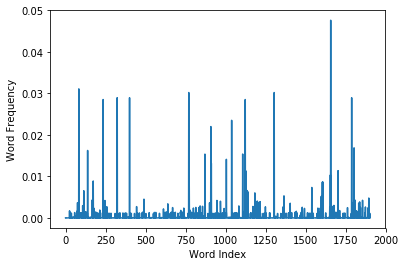

In [12]:
plt.plot(WordFrequency.Frequency)
plt.xlabel('Word Index')
plt.ylabel('Word Frequency')
plt.show()

### Sort WordFrequency in descending order

In [13]:
WordFrequency_sort = WordFrequency.sort_values(by='Frequency', ascending=False)
WordFrequency_sort.head()

,Word,Count,Frequency
1657,the,2656,0.047622
83,and,1734,0.031090
770,harry,1685,0.030212
1304,potter,1685,0.030212
323,code,1616,0.028975


## Model 1: Naive Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
clf1 = MultinomialNB()

In [16]:
cross_val_acc = cross_val_score(clf1, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_acc)
print(cross_val_acc.mean())

[0.97007042 0.99119718 0.98591549 0.97183099 0.98233216 0.97349823
 0.97879859 0.98233216 0.97879859 0.9770318 ]
0.9791805603941672


In [17]:
clf1.fit(train_vector, data_train.label.values)
predictions = clf1.predict(test_vector)

In [18]:
solution1 = pd.DataFrame(list(zip(data_test.sentence, predictions)), columns=['sentence', 'label'])

In [19]:
solution1.to_csv('./solution1_naive_bayes.csv', index=False)
# Accuracy in testing data: 0.97461

## Model 2: Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_jobs=-1)

In [21]:
cross_val_acc2 = cross_val_score(clf2, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_acc2)
print(cross_val_acc2.mean())

[0.97711268 0.98767606 0.98591549 0.98943662 0.98233216 0.97879859
 0.98056537 0.98586572 0.98233216 0.98233216]
0.9832366993480317


In [22]:
clf2.fit(train_vector, data_train.label.values)
prediction2 = clf2.predict(test_vector)

In [23]:
solution2 = pd.DataFrame(list(zip(data_test.sentence, prediction2)), columns=['sentence','label'])

In [24]:
solution2.to_csv('./solution2_random_forest.csv', index=False)
# Accuracy in testing data: 0.97884

### Use GridSearchCV

In [25]:
from pprint import pprint
from sklearn.model_selection import GridSearchCV

In [26]:
pprint(clf2.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [27]:
param_grid = {
             'class_weight': ['balanced', None],
             'criterion': ['gini', 'entropy'],
             'max_depth': [None, 1, 5, 10],
             'max_features': ['auto', 'log2', None],
             'n_estimators': [5, 10, 20]}
cv_clf2 = GridSearchCV(estimator=clf2, param_grid=param_grid, scoring='accuracy', verbose=0, n_jobs=-1)
cv_clf2.fit(train_vector, data_train.label.values)
best_parameters = cv_clf2.best_params_
print('The best parameters for using RF model is: ', best_parameters)

The best parameters for using RF model is:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'n_estimators': 5}


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:735: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
clf2_balanced_gini = RandomForestClassifier(class_weight='balanced', n_estimators=20)
clf2_entropy = RandomForestClassifier(criterion='entropy', n_estimators=20)
clf2_gini = RandomForestClassifier(n_estimators=20)

In [29]:
RF_score1 = cross_val_score(clf2_balanced_gini, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(RF_score1)
print(RF_score1.mean())

[0.97359155 0.99471831 0.99471831 0.99647887 0.98409894 0.97349823
 0.98409894 0.99293286 0.98763251 0.98763251]
0.9869401035186384


In [30]:
RF_score2 = cross_val_score(clf2_entropy, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(RF_score2)
print(RF_score2.mean())

[0.9806338  0.99471831 0.98591549 0.98943662 0.98586572 0.98056537
 0.98586572 0.99116608 0.98586572 0.98586572]
0.9865898571641866


In [31]:
RF_score3 = cross_val_score(clf2_gini, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(RF_score3)
print(RF_score3.mean())

[0.97007042 0.98767606 0.98943662 0.98943662 0.98233216 0.97349823
 0.98586572 0.99293286 0.98939929 0.98939929]
0.9850047280147315


In [32]:
clf2_balanced_gini.fit(train_vector, data_train.label.values)
prediction2_tuned = clf2_balanced_gini.predict(test_vector)
solution2_tuned = pd.DataFrame(list(zip(data_test.sentence, prediction2_tuned)), columns=['sentence', 'label'])

In [33]:
solution2_tuned.to_csv('./solution2_RF_tuned.csv', index=False)

## Model 3: Logistic Regression (Use GridSearchCV to tune hyper-parameters)

In [34]:
# Use Logistic Regression directly
from sklearn.linear_model import LogisticRegression
clf3_1 = LogisticRegression()

In [35]:
cross_val_acc3_1 = cross_val_score(clf3_1, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_acc3_1)
print(cross_val_acc3_1.mean())

[0.98591549 0.99823944 0.99295775 0.99471831 0.99293286 0.99116608
 0.99116608 0.99293286 0.99469965 0.98763251]
0.992236102125118


### Use GridSearchCV

In [36]:
pprint(clf3_1.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [37]:
param_grid = {'penalty': ['l1', 'l2'],
             'class_weight': ['balanced', None],
             'C': [0.1, 1, 10]
             }
clf3_2 = GridSearchCV(estimator=clf3_1, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
clf3_2.fit(train_vector, data_train.label.values)
best_param = clf3_2.best_params_
print('The best parameters for using LR model is: ', best_param)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  10 out of  36 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.3s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:735: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters for using LR model is:  {'C': 10, 'class_weight': None, 'penalty': 'l2'}


In [38]:
clf3_2 = LogisticRegression(C=9.4)
cross_val_acc3_2 = cross_val_score(clf3_2, train_vector, data_train.label.values, cv=10, scoring='accuracy')
print(cross_val_acc3_2)
print(cross_val_acc3_2.mean())

[0.98943662 0.99823944 0.99295775 0.99647887 0.99469965 0.99293286
 0.99116608 0.99293286 0.99293286 0.99116608]
0.9932943064748917


In [39]:
clf3_1.fit(train_vector, data_train.label.values)
clf3_2.fit(train_vector, data_train.label.values)
prediction3_1 = clf3_1.predict(test_vector)
prediction3_2 = clf3_2.predict(test_vector)

In [40]:
solution3_origin_LR = pd.DataFrame(list(zip(data_test.sentence, prediction3_1)), columns=['sentence', 'label'])
solution3_CV_LR = pd.DataFrame(list(zip(data_test.sentence, prediction3_2)), columns=['sentence', 'label'])

In [41]:
solution3_origin_LR.to_csv('./solution3_origin_LR.csv', index=False)
# Accuracy in testing data: 0.99083

In [42]:
solution3_CV_LR.to_csv('./solution3_CV_LR.csv', index=False)
# Accuracy in testing data:0.99083

## Model 4: RNN

In [43]:
import os
import sys
import time

class Dataset():
    def __init__(self,data,label):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._label = label
        assert(data.shape[0] == label.shape[0])
        self._num_examples = data.shape[0]
        pass

    @property
    def data(self):
        return self._data
    
    @property
    def label(self):
        return self._label

    def next_batch(self,batch_size,shuffle = True):
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples
            self._label = self.label[idx]

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            label_rest_part = self.label[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples
            self._label = self.label[idx0]

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            label_new_part = self._label[start:end]
            return np.concatenate((data_rest_part, data_new_part), axis=0),np.concatenate((label_rest_part, label_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end],self._label[start:end]

class ProgressBar():
    def __init__(self,worksum,info="",auto_display=True):
        self.worksum = worksum
        self.info = info
        self.finishsum = 0
        self.auto_display = auto_display
    def startjob(self):
        self.begin_time = time.time()
    def complete(self,num):
        self.gaptime = time.time() - self.begin_time
        self.finishsum += num
        if self.auto_display == True:
            self.display_progress_bar()
    def display_progress_bar(self):
        percent = self.finishsum * 100 / self.worksum
        eta_time = self.gaptime * 100 / (percent + 0.001) - self.gaptime
        strprogress = "[" + "=" * int(percent // 2) + ">" + "-" * int(50 - percent // 2) + "]"
        str_log = ("%s %.2f %% %s %s/%s \t used:%ds eta:%d s" % (self.info,percent,strprogress,self.finishsum,self.worksum,self.gaptime,eta_time))
        sys.stdout.write('\r' + str_log)

def get_dataset(paths):
    dataset = []
    for path in paths.split(':'):
        path_exp = os.path.expanduser(path)
        classes = os.listdir(path_exp)
        classes.sort()
        nrof_classes = len(classes)
        for i in range(nrof_classes):
            class_name = classes[i]
            facedir = os.path.join(path_exp, class_name)
            if os.path.isdir(facedir):
                images = os.listdir(facedir)
                image_paths = [os.path.join(facedir,img) for img in images]
                dataset.append(ImageClass(class_name, image_paths))
  
    return dataset

class ImageClass():
    "Stores the paths to images for a given class"
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
  
    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'
  
    def __len__(self):
        return len(self.image_paths)

def split_dataset(dataset, split_ratio, mode):
    if mode=='SPLIT_CLASSES':
        nrof_classes = len(dataset)
        class_indices = np.arange(nrof_classes)
        np.random.shuffle(class_indices)
        split = int(round(nrof_classes*split_ratio))
        train_set = [dataset[i] for i in class_indices[0:split]]
        test_set = [dataset[i] for i in class_indices[split:-1]]
    elif mode=='SPLIT_IMAGES':
        train_set = []
        test_set = []
        min_nrof_images = 2
        for cls in dataset:
            paths = cls.image_paths
            np.random.shuffle(paths)
            split = int(round(len(paths)*split_ratio))
            if split<min_nrof_images:
                continue  # Not enough images for test set. Skip class...
            train_set.append(ImageClass(cls.name, paths[0:split]))
            test_set.append(ImageClass(cls.name, paths[split:-1]))
    else:
        raise ValueError('Invalid train/test split mode "%s"' % mode)
    return train_set, test_set

In [44]:
import collections
import tensorflow as tf
%matplotlib inline

In [45]:
data_train[data_train['label'] == 1].sentence.values

array(['Brokeback Mountain was so awesome.',
       'I am going to start reading the Harry Potter series again because that is one awesome story.',
       'I am going to start reading the Harry Potter series again because that is one awesome story.',
       ..., 'Brokeback Mountain was so awesome.',
       'Brokeback Mountain was so awesome.',
       'The Da Vinci Code was absolutely AWESOME!'], dtype=object)

In [46]:
pos_lines = []
pess_lines = []

pb = ProgressBar(worksum=10000000)
pb.startjob()

for pos_line in data_train[data_train['label'] == 1].sentence.values:
    pos_linesp = [i.lower() for i in pos_line.strip("\n").split()]
    pos_lines.append(pos_linesp)

for pess_line in data_train[data_train['label'] == 0].sentence.values:
    pess_linesp = [i.lower() for i in pess_line.strip("\n").split()]
    pess_lines.append(pess_linesp)




# if len(pos_linesp) <= sentlength and len(pess_linesp) <= sentlength:
#     pos_lines.append(pos_linesp)
#     pess_lines.append(pess_linesp)
# if (num // 2) % 1000 == 0:
#     pb.complete(1000)
            
        #if num // 2 >= 1000000:
        #    break

In [47]:
len(pos_lines), len(pess_lines)

(3204, 2464)

In [48]:
words = []

for sent in pos_lines:
    for word in sent:
        words.append(word)
        
for sent in pess_lines:
    for word in sent:
        words.append(word)

In [49]:
from collections import Counter

In [50]:
Counter(words).most_common(15)

[('i', 3661),
 ('the', 2589),
 ('and', 1730),
 ('harry', 1680),
 ('vinci', 1615),
 ('da', 1613),
 ('brokeback', 1590),
 ('code', 1313),
 ('love', 1245),
 ('is', 1223),
 ('a', 973),
 ('mountain', 972),
 ('was', 939),
 ('mission', 854),
 ('potter', 767)]

In [51]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

In [52]:
# to be Done!!!